In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!unzip /kaggle/input/tgs-salt-identification-challenge/train.zip -d train_data
!unzip /kaggle/input/tgs-salt-identification-challenge/test.zip -d test_data
image_dir = '/kaggle/working/train_data/images'
mask_dir = '/kaggle/working/train_data/masks'

Archive:  /kaggle/input/tgs-salt-identification-challenge/train.zip
   creating: train_data/images/
   creating: train_data/masks/
  inflating: train_data/images/8d08955cdf.png  
  inflating: train_data/images/e045664b46.png  
  inflating: train_data/images/4989c6509e.png  
  inflating: train_data/images/fff4eb4941.png  
  inflating: train_data/images/3a310860a3.png  
  inflating: train_data/images/7a696bb878.png  
  inflating: train_data/images/8d3ee9356b.png  
  inflating: train_data/images/213e0a9f7b.png  
  inflating: train_data/images/78f17697f2.png  
  inflating: train_data/images/bd20d18369.png  
  inflating: train_data/images/de08c5a3b7.png  
  inflating: train_data/images/f06ef6c8b7.png  
  inflating: train_data/images/b2d02516e1.png  
  inflating: train_data/images/5edb37f5a8.png  
  inflating: train_data/images/b1f0e104f5.png  
  inflating: train_data/images/40e8e14e60.png  
  inflating: train_data/images/6e1444d88d.png  
  inflating: train_data/images/f342603c76.png  
  inf

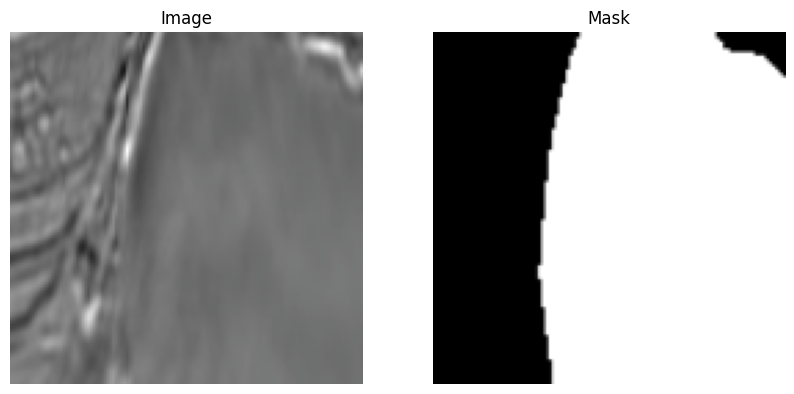

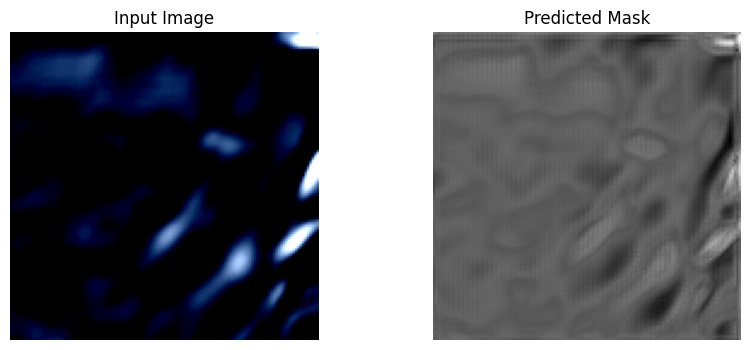

In [3]:
# %%
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns  
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from sklearn.model_selection import train_test_split

# %%
# train_dir = r'D:\TGS Salt\train'


# # %%
# image_dir = 'train\images'
# mask_dir = 'train\masks'
# Get all image filenames (assuming masks have the same names)
image_filenames = sorted(os.listdir(image_dir))
train_files, val_files = train_test_split(
    image_filenames, test_size=0.2, random_state=42)
# %%
class SaltDataset(Dataset):
    def __init__(self, image_dir, mask_dir, file_list, image_transform=None, mask_transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.file_list = file_list
        self.image_transform = image_transform
        self.mask_transform = mask_transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_name = self.file_list[idx]
        img_path = os.path.join(self.image_dir, img_name)
        mask_path = os.path.join(self.mask_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')
        if self.image_transform:
            image = self.image_transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)
        return image, mask

# %%
image_transform = T.Compose([
    T.Resize((128, 128)),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

mask_transform = T.Compose([
    T.Resize((128, 128)),
    T.ToTensor(),  # will keep mask as [1, H, W]
])


# %%
# train_dataset = SaltDataset(image_dir,mask_dir,image_transform, mask_transform)
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
train_dataset = SaltDataset(image_dir, mask_dir, train_files, image_transform, mask_transform)
val_dataset = SaltDataset(image_dir, mask_dir, val_files, image_transform, mask_transform)
# %%
train_dataset[0][0].shape

# %%
import matplotlib.pyplot as plt

# Pick one sample (e.g., the first one)
image, mask = train_dataset[20]

# Convert tensors to numpy arrays for visualization
# For image: [C, H, W] -> [H, W, C]
img_np = image.permute(1, 2, 0).cpu().numpy()
# For mask: [1, H, W] -> [H, W]
mask_np = mask.squeeze().cpu().numpy()

# Undo normalization for visualization if needed
# (If you used normalization in image_transform)
img_np = img_np * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
img_np = img_np.clip(0, 1)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Image")
plt.imshow(img_np)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Mask")
plt.imshow(mask_np, cmap='gray')
plt.axis('off')

plt.show()

# %%
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch, dropout=0.0):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Dropout2d(dropout),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Dropout2d(dropout)
        )
    def forward(self, x):
        return self.double_conv(x)


class Unet(nn.Module):
    def __init__(self):
        super(Unet, self).__init__()
        self.enc1 = DoubleConv(3,64)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = DoubleConv(64,128)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = DoubleConv(128,256)
        self.pool3 = nn.MaxPool2d(2)
        self.enc4 = DoubleConv(256,512)
        self.pool4 = nn.MaxPool2d(2)
        
        self.bottleneck = DoubleConv(512,1024)

        self.up4 = nn.ConvTranspose2d(1024,512,2,stride=2)
        self.dec4 = DoubleConv(1024,512)
        self.up3 = nn.ConvTranspose2d(512,256,2,stride=2)
        self.dec3 = DoubleConv(512,256)
        self.up2 = nn.ConvTranspose2d(256,128,2,stride=2)
        self.dec2 = DoubleConv(256,128)
        self.up1 = nn.ConvTranspose2d(128,64,2,stride=2)
        self.dec1 = DoubleConv(128,64)

        self.final = nn.Conv2d(64,1,1)
        

    def forward(self,x):
        e1 = self.enc1(x)
        p1 = self.pool1(e1)
        e2 = self.enc2(p1)
        p2 = self.pool2(e2)
        e3 = self.enc3(p2)
        p3 = self.pool3(e3)
        e4 = self.enc4(p3)
        p4 = self.pool4(e4)

        b = self.bottleneck(p4)

        #decoder
        d4 = self.up4(b)
        d4 = torch.cat([d4,e4],dim=1)
        d4 = self.dec4(d4)
        d3 = self.up3(d4)
        d3 = torch.cat([d3,e3],dim=1)
        d3 = self.dec3(d3)
        d2 = self.up2(d3)
        d2 = torch.cat([d2,e2],dim=1)
        d2 = self.dec2(d2)
        d1 = self.up1(d2)
        d1 = torch.cat([d1,e1],dim=1)
        d1 = self.dec1(d1)

        out = self.final(d1)

        return out


# %%
model = Unet()

# %%
x = torch.rand(1,3,128,128)

# %%
model(x)

# %%
import matplotlib.pyplot as plt

# Take a sample from your dataset (e.g., the first one)
sample_img, _ = train_dataset[10]  # (image, mask)
input_img = sample_img.unsqueeze(0)  # Add batch dimension

# Put model in eval mode and get output
model.eval()
with torch.no_grad():
    output = model(input_img)
    output = torch.sigmoid(output)
    output_mask = output.squeeze().cpu().numpy()

# Show input and output
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.title("Input Image")
plt.imshow(sample_img.permute(1,2,0).cpu().numpy())
plt.axis('off')

plt.subplot(1,2,2)
plt.title("Predicted Mask")
plt.imshow(output_mask, cmap='gray')
plt.axis('off')
plt.show()

# %%





In [4]:
import torch
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


# Hyperparameters
num_epochs = 50
learning_rate = 1e-3
batch_size = 32  # As defined in your DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
save_path = "unet_salt_model.pth"

# Model, Loss, Optimizer
model = Unet().to(device)
criterion = nn.BCEWithLogitsLoss()  # Suitable for binary segmentation
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

# Training Loop with Loss Tracking
def train_model(model, train_loader, criterion, optimizer, scheduler, num_epochs, device, save_path):
    best_loss = float('inf')
    train_losses = []  # To store average loss per epoch
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=True)

        for images, masks in loop:
            images, masks = images.to(device), masks.to(device)

            # Forward pass
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Track loss
            running_loss += loss.item() * images.size(0)
            loop.set_postfix(loss=loss.item())

        # Compute and log epoch loss
        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

        # Update learning rate
        scheduler.step(epoch_loss)

        # Save best model
        if epoch_loss < best_loss:
            best_loss = epoch_loss
            torch.save(model.state_dict(), save_path)
            print(f"Saved model with loss: {best_loss:.4f}")

        # Visualize predictions every 5 epochs
        if (epoch + 1) % 5 == 0:
            model.eval()
            with torch.no_grad():
                sample_img, sample_mask = next(iter(train_loader))
                sample_img = sample_img[0].unsqueeze(0).to(device)  # Single image
                pred = torch.sigmoid(model(sample_img)).squeeze().cpu().numpy()
                
                # Denormalize image for visualization
                img_np = sample_img.squeeze().permute(1, 2, 0).cpu().numpy()
                img_np = img_np * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
                img_np = img_np.clip(0, 1)

                plt.figure(figsize=(10, 4))
                plt.subplot(1, 2, 1)
                plt.title("Input Image")
                plt.imshow(img_np)
                plt.axis('off')
                plt.subplot(1, 2, 2)
                plt.title(f"Predicted Mask (Epoch {epoch+1})")
                plt.imshow(pred, cmap='gray')
                plt.axis('off')
                plt.show()
            model.train()

    # Plot training loss
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Epochs')
    plt.grid(True)
    plt.legend()
    plt.show()

# Assuming train_loader is already defined as in your code
# train_model(model, train_loader, criterion, optimizer, scheduler, num_epochs, device, save_path)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Eval from uploaded model

In [5]:
device = 'cuda'

In [6]:

model = Unet().to(device)
model.load_state_dict(torch.load('/kaggle/input/model-1/pytorch/default/1/unet_salt.pth', map_location='cpu'))
model.eval()

/tmp/ipykernel_19/1068304663.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/kaggle/input/model-1/pytorch/default/1/unet_salt.pth', ma

Unet(
  (enc1): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Dropout2d(p=0.0, inplace=False)
      (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU(inplace=True)
      (7): Dropout2d(p=0.0, inplace=False)
    )
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc2): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Dropout2d(p=0.0, inplace=False)
      (4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), paddi

In [7]:
import os
import pandas as pd
import numpy as np
from PIL import Image
from tqdm import tqdm
import torch
import torchvision.transforms as T

def rle_encode(mask):
    '''
    mask: numpy array, 1 - mask, 0 - background
    Returns run length as string formatted
    '''
    pixels = mask.flatten(order='F')
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

test_dir = '/kaggle/working/test_data/images'
test_files = sorted(os.listdir(test_dir))
results = []

# Use the same transforms as used for validation (resize, tensor, normalize)
val_transform = T.Compose([
    T.Resize((128, 128)),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

model.eval()
for fname in tqdm(test_files):
    img_path = os.path.join(test_dir, fname)
    image = Image.open(img_path).convert('RGB')
    orig_size = image.size  # (width, height)
    input_tensor = val_transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        pred = model(input_tensor)
        pred = torch.sigmoid(pred)
        pred = (pred > 0.5).float()
        mask = pred.squeeze().cpu().numpy().astype(np.uint8)
    # Resize mask back to original size
    mask = Image.fromarray(mask)
    mask = mask.resize(orig_size, resample=Image.NEAREST)
    mask = np.array(mask)
    rle = rle_encode(mask)
    img_id = os.path.splitext(fname)[0]
    results.append({'id': img_id, 'rle_mask': rle})

# Save to CSV
df = pd.DataFrame(results)
df.to_csv('submission.csv', index=False)

100%|██████████| 18000/18000 [02:27<00:00, 122.30it/s]


In [8]:
# import os
# import numpy as np 
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns  
# from PIL import Image
# import torch
# import torch.nn as nn
# from torch.utils.data import Dataset, DataLoader
# import torchvision.transforms as T
# import cv2

In [9]:
# !unzip /kaggle/input/tgs-salt-identification-challenge/competition_data.zip

In [10]:
# !unzip /kaggle/input/tgs-salt-identification-challenge/train.zip -d train_data
# !unzip /kaggle/input/tgs-salt-identification-challenge/test.zip -d test_data
# image_dir = '/kaggle/working/train_data/images'
# mask_dir = '/kaggle/working/train_data/masks'